In [1]:
# Requirements

# !pip uninstall -y pylibcudagraph-cu12 rmm-cu12 && pip install  pandas numpy pillow torch torchvision transformers scikit-learn timeout-decorator peft accelerate datasets bitsandbytes bert-score rouge-score rapidfuzz sentence-transformers evaluate

In [2]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from transformers import (
    ViltProcessor,
    ViltModel,

    PreTrainedModel,
    Trainer,
ViltForQuestionAnswering,
    TrainingArguments,
    ViltConfig
)
from transformers.modeling_outputs import SequenceClassifierOutput
from peft import get_peft_model, LoraConfig
from accelerate import Accelerator
import torch.nn as nn
from sklearn.metrics import accuracy_score
from bert_score import score as bert_score_fn
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')


## Dataset

In [3]:
train_df = pd.read_csv('/kaggle/input/dataset/train_datapoints.csv')
val_df = pd.read_csv('/kaggle/input/dataset/val_datapoints.csv')

print(f"Training dataset with {len(train_df)} entries")
print(f"Validation dataset with {len(val_df)} entries")


Training dataset with 56000 entries
Validation dataset with 14000 entries


In [6]:
train_df["full_image_path"] = train_df["full_image_path"].apply(lambda p: p.replace("\\", "/"))
train_df["full_image_path"] = train_df["full_image_path"].apply(lambda p: str(Path("/kaggle/input") / p))

val_df["full_image_path"] = val_df["full_image_path"].apply(lambda p: p.replace("\\", "/"))
val_df["full_image_path"] = val_df["full_image_path"].apply(lambda p: str(Path("/kaggle/input") / p))


## BaseLine Model

In [28]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa").to(device)
import inflect
inflect_engine = inflect.engine()

In [29]:
# Normalize text-based answers
def normalize_answer(ans):
    if not isinstance(ans, str): 
        return ""  
    
    ans = ans.strip().lower()
    ans = re.sub(r'[^\w\s]', '', ans)  
    if ans.isdigit():
        ans = inflect_engine.number_to_words(ans)
    words = ans.split()
    return words[0] if words else ""  


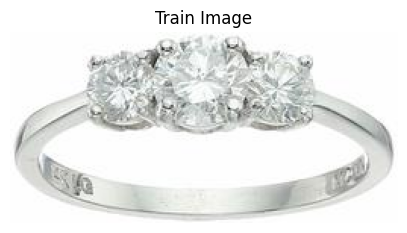

In [7]:
# Loading and display a single image to check image path
image_path = train_df.iloc[0]['full_image_path']
image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.title('Train Image')
plt.show()

In [31]:

def evaluate(df, split_name="Split", save_csv_path=None):
    print(f"\n Evaluating split: {split_name}")
    
    all_preds = []
    all_labels = []
    all_questions = []
    all_image_paths = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Running ViLT on {split_name}"):
        try:
            image = Image.open(row['full_image_path']).convert("RGB")
        except:
            continue

        question = row['question']
        
        if pd.isna(row['answer']) or row['answer'] is None:
            continue  
        
        actual_answer = normalize_answer(row['answer'])

        try:
            inputs = processor(image, question, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                pred_id = outputs.logits.argmax(-1).item()
                pred_raw = model.config.id2label[pred_id].lower()
                pred = normalize_answer(pred_raw)
        except:
            continue

        all_preds.append(pred)
        all_labels.append(actual_answer)
        all_questions.append(question)
        all_image_paths.append(row['full_image_path'])

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n Accuracy on {split_name}: {accuracy * 100:.2f}%")

    # P, R, F1 = bert_score(all_preds, all_labels, lang="en", verbose=True)
    # print(f" BERTScore - Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, zero_division=0))

    if save_csv_path is not None:
        out_df = pd.DataFrame({
            "image_path": all_image_paths,
            "question": all_questions,
            "predicted_answer": all_preds,
            "actual_answer": all_labels
        })
        out_df.to_csv(save_csv_path, index=False)
        print(f"Predictions saved to {save_csv_path}")

    return {
        "accuracy": accuracy,
        "bertscore": {"precision": P.mean().item(), "recall": R.mean().item(), "f1": F1.mean().item()},
        "predictions": all_preds,
        "labels": all_labels}



## We save prediction csv here and detailed evaluation using this csv is done in Final_Evaluation notebook

In [32]:
itrain_metrics = evaluate(train_df, "Train", save_csv_path="train_predictions_Vilt_baseline.csv")

print("\n Train Evaluation Metrics:")
print(train_metrics)


 Evaluating split: Train


Running ViLT on Train: 100%|██████████| 14430/14430 [07:32<00:00, 31.89it/s]



 Accuracy on Train: 27.53%

 Classification Report:
                  precision    recall  f1-score   support

             14k       0.00      0.00      0.00         1
               3       0.00      0.00      0.00         0
              3d       0.00      0.00      0.00         2
               a       0.00      0.00      0.00         9
             a71       0.00      0.00      0.00         1
          aayega       0.00      0.00      0.00         1
       abducting       0.00      0.00      0.00         1
           above       0.51      0.73      0.60       296
        abstract       0.33      0.06      0.10        18
          adidas       0.00      0.00      0.00         0
       adventure       0.00      0.00      0.00         1
           after       0.00      0.00      0.00         0
        airplane       0.00      0.00      0.00         1
             all       0.00      0.00      0.00         5
          almost       0.00      0.00      0.00         7
           alone  

NameError: name 'P' is not defined